<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/banner-spectral.png" width="1000" align="middle"/>


# <font color='#ECA702'>**Hands-on Sesi√≥n 4: Clasificacion espectral üì∏ üåà**</font>

# <font color='#4C5FDA'>**Objetivo**</font>



El objetivo de la clasificaci√≥n hiperespectral es clasificar cada p√≠xel/punto de datos en una de $K$ clases.  En general, los m√©todos de clasificaci√≥n son m√°s eficaces que los de desmezcla hiperespectral. Sin embargo, los m√©todos de clasificaci√≥n no son eficaces a la hora de determinar las cantidades de proporci√≥n subp√≠xel o la cantidad de un material que puede encontrarse dentro del campo de visi√≥n correspondiente a un p√≠xel.  

En general, los enfoques de clasificaci√≥n hiperespectral implican:
1. (opcionalmente) extracci√≥n de caracter√≠sticas
2. aplicaci√≥n de un clasificador est√°ndar (es decir, clasificadores de la bibliograf√≠a sobre aprendizaje autom√°tico).

Para esta sesi√≥n haremos uso de 3 clasificadores comunes segun el estado del arte en la calsificacion espectral de im√°genes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session")
github_url = 'https://github.com/CristianR8/Parte1-Sesion4---Imagenes-Espectrales/archive/main.zip'



<font color='#4C5FDA'>**Importamos librerias**</font>

In [ ]:
!pip install earthpy

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20.6/20.6 MB 50.8 MB/s eta 0:00:00


In [ ]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
import warnings
import joblib
import seaborn as sns
import torch.nn.functional as F
import torch.utils.data as data_utils
import seaborn as sns
import torch
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score
from torch import nn
from torch import optim



sns.set()
warnings.filterwarnings("ignore")



<font color='#4C5FDA'>**Informaci√≥n del Dataset**</font>

El conjunto de datos de la Universidad de Pav√≠a es un conjunto de datos de im√°genes hiperespectrales recogidas por un sensor conocido como espectr√≥metro de im√°genes de sistema √≥ptico reflectante (ROSIS-3) sobre la ciudad de Pav√≠a, Italia. La imagen consta de 610√ó340 p√≠xeles con 115 bandas espectrales. La imagen se divide en 9 clases con un total de 42.776 muestras etiquetadas, entre las que se incluyen el asfalto, los prados, la grava, los √°rboles, la chapa met√°lica, el suelo desnudo, el bet√∫n, el ladrillo y la sombra.

[Imagen de muestra]

<font color='#4C5FDA'>**Cargamos el nuevo conjunto de datos**</font>

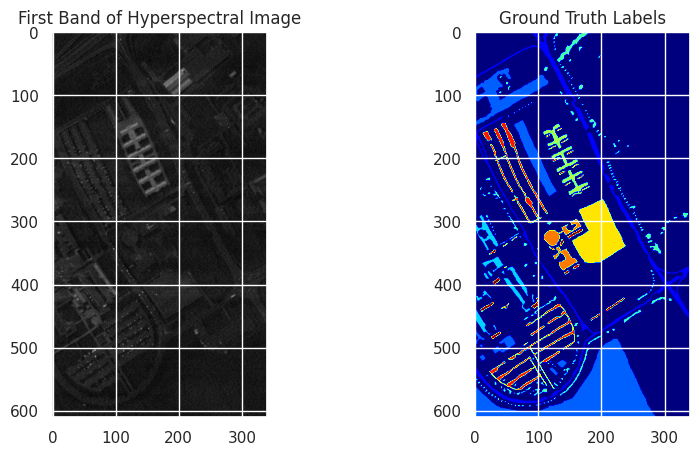

In [ ]:
def load_paviau_dataset(data_path, ground_truth_path):

    data = loadmat(data_path)
    gt = loadmat(ground_truth_path)

    # Assuming the variable names in the .mat files are 'paviaU' and 'paviaU_gt' respectively.
    # Adjust the keys if they are different in your dataset files.
    img = data['paviaU']
    gt = gt['paviaU_gt']

    return img, gt


def preprocess_data(img, gt):
    n_rows, n_cols, n_bands = img.shape
    pixels = img.reshape((n_rows*n_cols, n_bands))
    labels = gt.ravel()
    return pixels, labels

# Example usage:
data_path = '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/PaviaU.mat'  # Update this path
ground_truth_path = '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/PaviaU_gt.mat'  # Update this path
img, gt = load_paviau_dataset(data_path, ground_truth_path)

# Display the first band of the image and the ground truth to verify
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('First Band of Hyperspectral Image')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth Labels')
plt.show()


<font color='#4C5FDA'>**Preparaci√≥n de los datos para el clasificador KNN**</font>


Ahora podemos importar nuestro conjunto de datos de im√°genes a√©reas y convertirlo en un formato tabular para facilitar las operaciones de procesamiento sobre √©l. En este caso, cada banda de imagen se convierte en una columna **(¬°tenemos m√°s de 100 bandas!)**, y se crea una columna de clase para almacenar los datos sobre nuestras etiquetas, con cada objeto clasificado posible representado como un n√∫mero (en total 10). Luego se eliminan los elementos asociados con la clase 0, ya que la clase 0 se ha utilizado como una categor√≠a general para todos los objetos no clasificados en la imagen.

In [ ]:
n_rows, n_cols, n_bands = img.shape
pixels = img.reshape((n_rows*n_cols, n_bands))
labels = gt.ravel()
pixels, labels

pixels, labels = preprocess_data(img, gt)
# Filter out the pixels with no ground truth label
pixels = pixels[labels > 0]
labels = labels[labels > 0]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.3, random_state=42)


## <font color='#ECA702'>**Reto #1 üí™**</font>
Construye el clasificador KNN, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


Accuracy: 0.9071923946076521
Indice Jaccard:  0.8183532871252422
Reporte de clasificacion:
              precision    recall  f1-score   support

           1       0.95      0.92      0.93      1994
           2       0.91      0.98      0.94      5617
           3       0.76      0.78      0.77       648
           4       0.98      0.88      0.93       894
           5       0.99      1.00      1.00       414
           6       0.90      0.71      0.79      1508
           7       0.82      0.87      0.84       395
           8       0.84      0.85      0.85      1114
           9       1.00      1.00      1.00       249

    accuracy                           0.91     12833
   macro avg       0.91      0.89      0.89     12833
weighted avg       0.91      0.91      0.91     12833

Matriz de Confusion:


<Axes: >

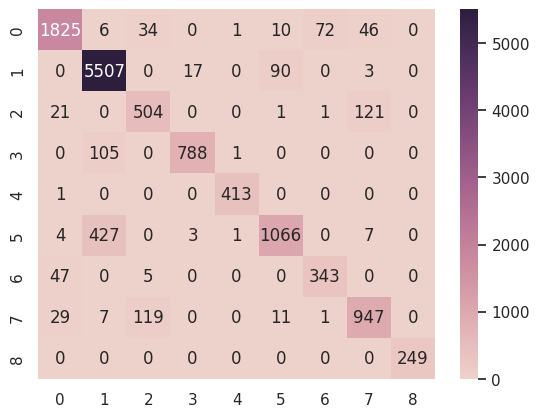

In [ ]:
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on the testing set
y_pred = knn.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro') )
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusion:")
cf_matrix_knn = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_knn, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')


In [ ]:
# Classify the entire image for visualization
full_img_prediction = knn.predict(img.reshape((-1, img.shape[2])))
pred_knn = full_img_prediction.reshape((img.shape[0], img.shape[1]))
gt_flat = gt.ravel()
mask = gt_flat != 0
gt_filtered = gt_flat[mask]
full_img_prediction_filtered = full_img_prediction[mask]

print("Accuracy:", accuracy_score(gt_filtered, full_img_prediction_filtered))
print("Reporte de clasificacion:")
print(classification_report(gt_flat, full_img_prediction))

Accuracy: 0.9264307088086777
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    164624
           1       0.17      0.93      0.28      6631
           2       0.24      0.99      0.39     18649
           3       0.24      0.81      0.37      2099
           4       0.13      0.90      0.22      3064
           5       0.44      1.00      0.61      1345
           6       0.11      0.77      0.19      5029
           7       0.43      0.88      0.58      1330
           8       0.22      0.90      0.35      3682
           9       0.09      1.00      0.16       947

    accuracy                           0.19    207400
   macro avg       0.21      0.82      0.32    207400
weighted avg       0.04      0.19      0.07    207400



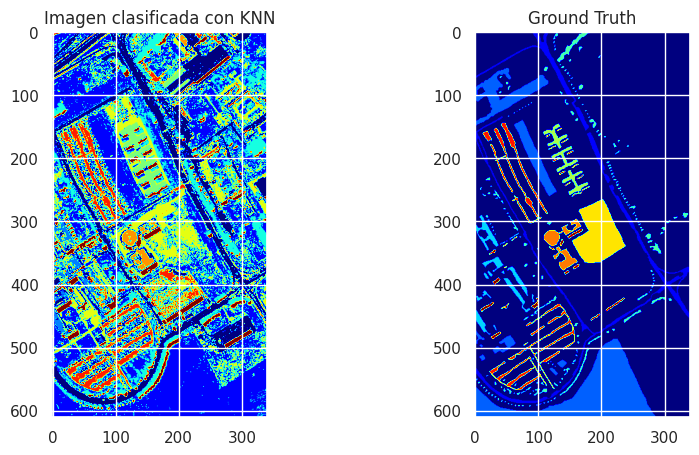

In [ ]:
# Plot the classified image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_knn, cmap='jet')
plt.title('Imagen clasificada con KNN')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

<font color='#4C5FDA'>**Preprocesamiento para el clasifiicador Decision Tree**</font>

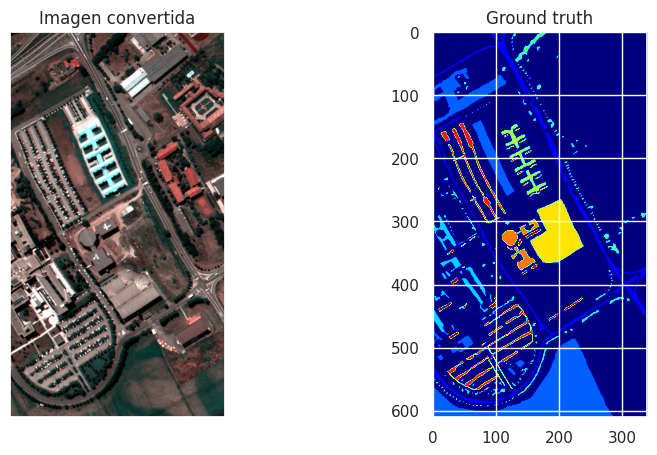

In [ ]:
df = pd.DataFrame(img.reshape(img.shape[0]*img.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df = df[df['class']!=0]

stacked_bands = np.transpose(img, (2, 0, 1))
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]])
bands = [f'Band {i}' for i in range(1, 102, 50)]
colors = list(mcolors.BASE_COLORS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
    ax=plt.gca(),
)
plt.title('Imagen convertida')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground truth')
plt.show()

## <font color='#ECA702'>**Reto #2 üí™**</font>
Construye el clasificador Decision Tree, ayudate de la documentacion oficial en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


Accuracy Score:  88.5 %
Indice Jaccard:  0.7767875136209388
Reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1989
           1       0.93      0.93      0.93      5595
           2       0.73      0.68      0.71       630
           3       0.90      0.91      0.91       919
           4       0.99      0.99      0.99       403
           5       0.79      0.80      0.80      1509
           6       0.76      0.77      0.77       399
           7       0.79      0.82      0.80      1105
           8       1.00      1.00      1.00       284

    accuracy                           0.88     12833
   macro avg       0.87      0.87      0.87     12833
weighted avg       0.88      0.88      0.88     12833

Confusion Matrix:


<Axes: >

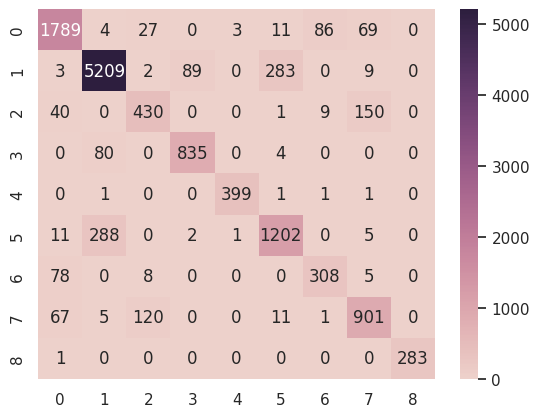

In [ ]:
x = df.drop(['class'], axis=1)
y = df['class']

le = preprocessing.LabelEncoder()
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, stratify = y)
y_encoder = le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(x_train.values, y_train)
y_pred = model.predict(x_test.values)

# Evaluation
print("Accuracy Score: ", round(accuracy_score(y_test, y_pred), 3)*100, "%")
print("Indice Jaccard: ", jaccard_score(y_test, y_pred, average='macro'))
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cf_matrix_dt = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix_dt, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='g')


In [ ]:
l = []
for i in range(img.shape[0]*img.shape[1]):
    if i in list(df.index):
        l.append(le.inverse_transform(model.predict([df.loc[i, :][:-1]])))
    else:
        l.append(0)

pred_dt = np.array(l, dtype=object).reshape(gt.shape).astype('float')

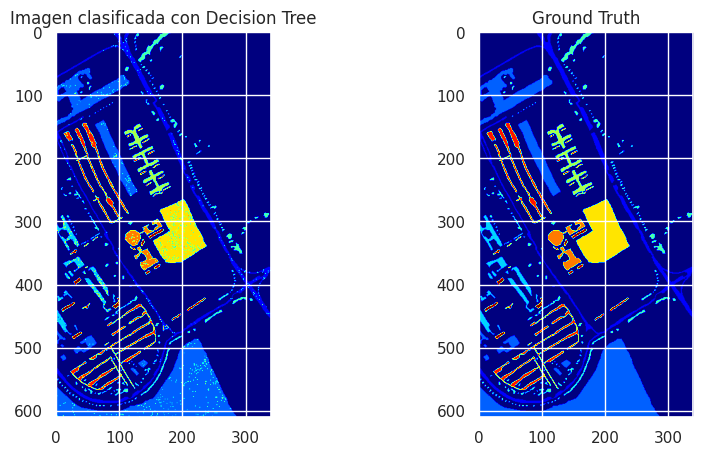

In [ ]:
# Plot the classified image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred_dt, cmap='jet')
plt.title('Imagen clasificada con Decision Tree')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

## <font color='#ECA702'>**Reto #3 üí™**</font>
Eval√∫a el modelo de redes neurronales que implementamos para que visualices los resultados de esta clasificaci√≥n.


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4]))
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

In [ ]:
model = torch.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/complete_model.pth')
model.eval()

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [ ]:
# Cargar el modelo PCA
pca = joblib.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/model_pca.pkl')

# Cargar los conjuntos de datos particionados
cnn_x_train = torch.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_x_train.pth')
cnn_x_test = torch.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_x_test.pth')
cnn_y_train = torch.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_y_train.pth')
cnn_y_test = torch.load('/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_y_test.pth')

In [ ]:
dimensions = 17
window_size = 25
test_perc = 0.3

# Aqu√≠ puedes continuar con la creaci√≥n de DataLoader para la evaluaci√≥n
# No necesitas aplicar PCA de nuevo, ya que los datos ya est√°n transformados y listos para usarse
test = torch.utils.data.TensorDataset(cnn_x_test, cnn_y_test)
testloader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [ ]:
def confusion_matrix(data, nb_classes):
    df_cm = pd.DataFrame(data,
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues',
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.show()

def acc_per_class(model, testloader, nb_classes):
    model.eval()
    confusion_mat = torch.zeros(nb_classes, nb_classes)
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    total = 0
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_mat[t.long(), p.long()] += 1

    confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes)

    per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
    for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
    acc = torch.mean(per_class_acc).data.cpu().numpy()
    print("Overall Accuracy: ", acc, "%")

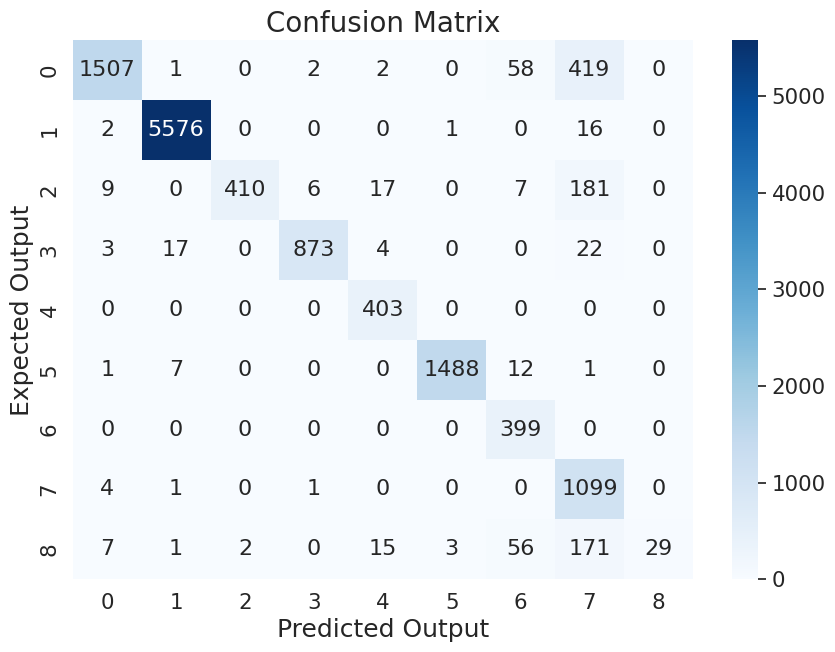

Class: 0 Accuracy: 75.766716
Class: 1 Accuracy: 99.66041
Class: 2 Accuracy: 65.07937
Class: 3 Accuracy: 94.99456
Class: 4 Accuracy: 100.0
Class: 5 Accuracy: 98.60835
Class: 6 Accuracy: 100.0
Class: 7 Accuracy: 99.457016
Class: 8 Accuracy: 10.211267
Overall Accuracy:  82.64197 %


In [ ]:
x = np.reshape(img, (-1, img.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (img.shape[0], img.shape[1], dimensions))
padded_x = zeros_pad(torch.tensor(x_pca), window_size//2)

pred = np.zeros((gt.shape[0], gt.shape[1]))
for h in range(gt.shape[0]):
    for w in range(gt.shape[1]):
        if int(gt[h, w]) == 0:
            continue
        else:
            model.eval()
            image_patch = padded_x[h:h+window_size, w:w+window_size, :]
            image = torch.permute(image_patch[None, None, :, :, :], (0, 1, 4, 2, 3))
            pred[h][w] = model(image).argmax(dim=1) + 1

acc_per_class(model, testloader, 9)


In [ ]:
def jaccard_coefficient(pred, gt, nb_classes):
    jaccard_per_class = np.zeros(nb_classes)
    for cls in range(1, nb_classes + 1):  # Class labels start from 1
        pred_cls = pred == cls
        gt_cls = gt == cls
        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()
        if union == 0:
            jaccard_per_class[cls - 1] = np.nan  # To handle division by zero
        else:
            jaccard_per_class[cls - 1] = intersection / union
    return np.nanmean(jaccard_per_class), jaccard_per_class  # Return average and per-class Jaccard


In [ ]:
# Example usage with placeholder data. Replace `pred` and `gt` with your model's data.
nb_classes = 9  # Number of classes, excluding the background class
avg_jaccard, jaccard_per_class = jaccard_coefficient(pred, gt, nb_classes)
print("Average Jaccard Coefficient:", avg_jaccard)
print("Jaccard Coefficient per Class:", jaccard_per_class)

Average Jaccard Coefficient: 0.7564105313039867
Jaccard Coefficient per Class: [0.7694258  0.99305556 0.70819517 0.93919793 0.92060233 0.97898493
 0.75611143 0.59385666 0.14826498]


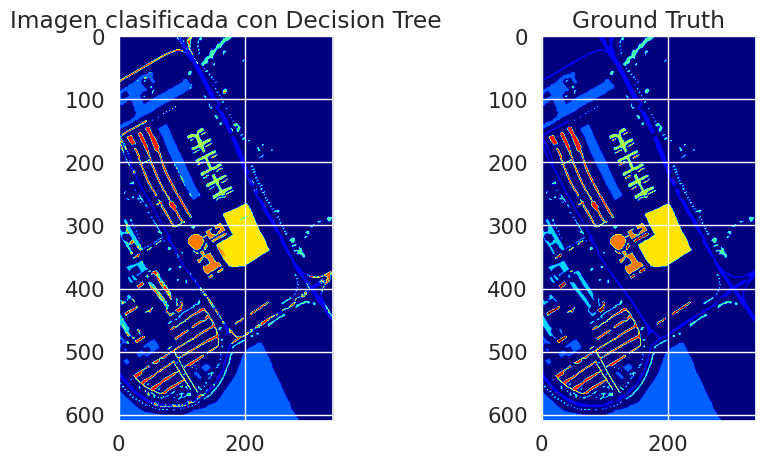

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred, cmap='jet')
plt.title('Imagen clasificada con Deep Learning')
plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Ground Truth')
plt.show()

# **<font color="#FF0000">E</font><font color="#FF7F00">x</font><font color="#FFFF00">t</font><font color="#00FF00">r</font><font color="#0000FF">a</font>**: Grafica los tres resultados de los tres clasificadores y compara los resultados de manera visual. ¬øCual crees que es el mejor clasificador y por qu√©?

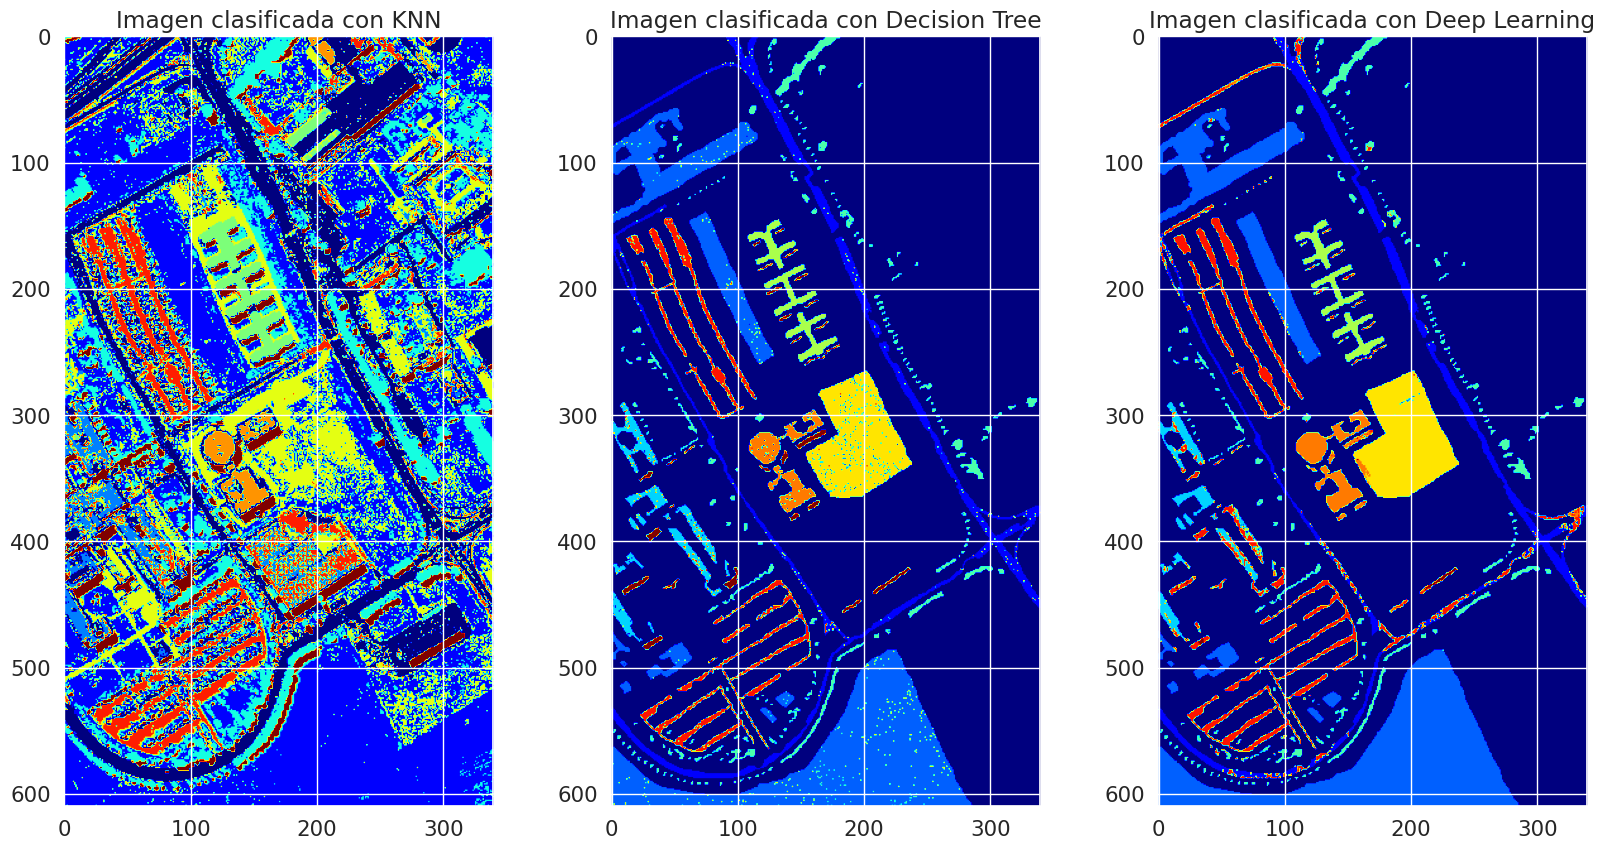

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(pred_knn, cmap='jet')
plt.title('Imagen clasificada con KNN')
plt.subplot(1, 3, 2)
plt.imshow(pred_dt, cmap='jet')
plt.title('Imagen clasificada con Decision Tree')
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='jet')
plt.title('Imagen clasificada con Deep Learning')
plt.show()